#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [ ]:
data_train1 = pd.read_csv(path + '/data01_train.csv')
data_train1.drop('subject', axis=1, inplace=True)
data_train1.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
data_test1 = pd.read_csv(path + '/data01_test.csv')
data_test1.drop('subject', axis=1, inplace=True)
data_test1.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [ ]:
feature = pd.read_csv(path + '/features.csv')
feature.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [ ]:
data_train1.shape

(5881, 562)

In [ ]:
data_train1.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
data_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [ ]:
data_test1.shape

(1471, 562)

In [ ]:
data_test1.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766


In [ ]:
data_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [ ]:
# 범주형 변수 단변량 분석 함수
def categorical_univariate_analysis(df, column):
    """
    범주형 변수를 단변량 분석하는 함수

    Parameters:
    df (pandas.DataFrame): 분석할 데이터프레임
    column (str): 분석할 변수의 칼럼명

    Returns:
    None
    """
    # 1. 결측치 확인
    missing = df[column].isnull().sum()
    print(f"Missing values: {missing}")

    # 2. 고유값 및 빈도수 출력
    print(f"\nUnique categories and counts in '{column}':")
    print(df[column].value_counts())

    # 3. 막대그래프 시각화
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=column)
    plt.title(f'Countplot of {column}')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
target = 'Activity'

Missing values: 0

Unique categories and counts in 'Activity':
Activity
LAYING                292
STANDING              287
SITTING               254
WALKING               228
WALKING_UPSTAIRS      215
WALKING_DOWNSTAIRS    195
Name: count, dtype: int64


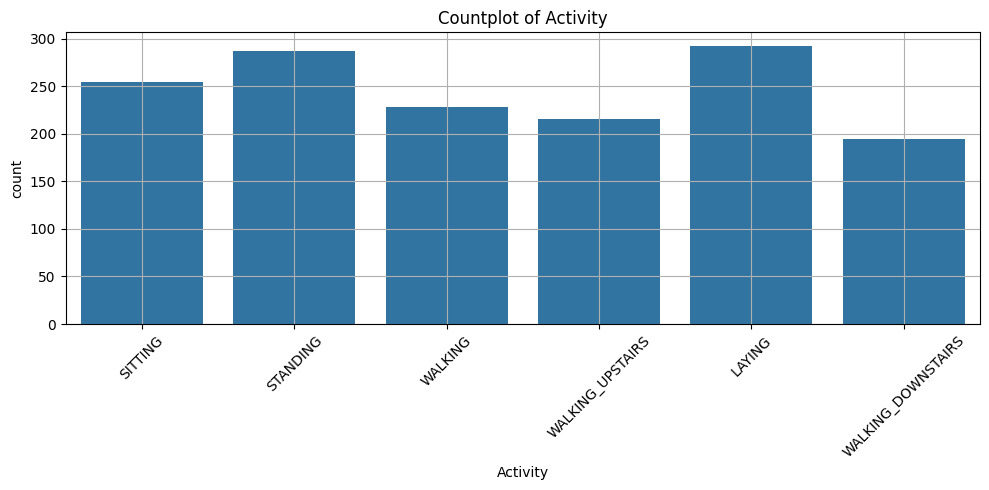

In [ ]:
categorical_univariate_analysis(data_test1, target)

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [ ]:
target = 'Activity'

x1 = data_test1.drop(target, axis=1)
y1 = data_test1.loc[:, target]

In [ ]:
from sklearn.model_selection import train_test_split
x_train1, x_val1, y_train1, y_val1 = train_test_split(x1, y1, test_size=0.2, random_state=1, stratify= y1)

#### 2) 모델링

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
model1 = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=1)
model1.fit(x_train1, y_train1)

RandomForestClassifier(max_depth=5, random_state=1)

In [ ]:
y_pred1 = model1.predict(x_val1)
print(confusion_matrix(y_val1, y_pred1))
print(classification_report(y_val1, y_pred1))

[[59  0  0  0  0  0]
 [ 1 38 12  0  0  0]
 [ 0  3 54  0  0  0]
 [ 0  0  0 43  1  2]
 [ 0  0  0  2 37  0]
 [ 0  0  0  1  2 40]]
                    precision    recall  f1-score   support

            LAYING       0.98      1.00      0.99        59
           SITTING       0.93      0.75      0.83        51
          STANDING       0.82      0.95      0.88        57
           WALKING       0.93      0.93      0.93        46
WALKING_DOWNSTAIRS       0.93      0.95      0.94        39
  WALKING_UPSTAIRS       0.95      0.93      0.94        43

          accuracy                           0.92       295
         macro avg       0.92      0.92      0.92       295
      weighted avg       0.92      0.92      0.92       295



#### 3) 변수 중요도 추출

In [ ]:
plot_feature_importance(model1.feature_importances_, x_train1.columns, result_only=True)

,feature_name,feature_importance
0,"angle(X,gravityMean)",0.044280
1,tGravityAcc-energy()-X,0.035585
2,tGravityAcc-mean()-X,0.030447
3,tGravityAcc-min()-X,0.029513
4,tGravityAcc-max()-Y,0.023855
...,...,...
556,"fBodyGyro-bandsEnergy()-25,32.1",0.000000
557,"fBodyAcc-bandsEnergy()-49,64",0.000000
558,"fBodyAcc-bandsEnergy()-17,24.1",0.000000
559,"fBodyAcc-bandsEnergy()-25,32.1",0.000000


### (2) 중요도 기반 feature 분석

In [ ]:
import matplotlib.patches as mpatches

def print_feature_graph(df, column):
  activity_palette = {
      'WALKING_DOWNSTAIRS': 'blue',
      'WALKING_UPSTAIRS': 'green',
      'WALKING': 'red',
      'LAYING': 'purple',
      'SITTING': 'orange',
      'STANDING': 'cyan'
  }

  legend_patches = [mpatches.Patch(color=color, label=activity) for activity, color in activity_palette.items()]

  plt.figure(figsize=(10, 6))
  sns.kdeplot(data=df, x=column, hue='Activity', fill=True, common_norm=False, palette=activity_palette)
  plt.title(f'KDE Plot of {column} and Activity')
  plt.xlabel(column)
  plt.ylabel('Density')

  plt.legend(handles=legend_patches, title='Activity', loc='center left', bbox_to_anchor=(1, 0.5))

  plt.show()

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [ ]:
top_n_features1 = ['angle(X,gravityMean)','angle(Y,gravityMean)','tGravityAcc-min()-X','tGravityAcc-max()-X','tGravityAcc-mean()-Y']
bottom_m_features1 = ['fBodyAccJerk-bandsEnergy()-57,64.2', 'fBodyAccJerk-bandsEnergy()-1,16.2','tGravityAccMag-min()'	,'fBodyAccJerk-bandsEnergy()-33,48.2','fBodyGyro-min()-Y']

#### 2) 상위 5개 변수에 대한 분석

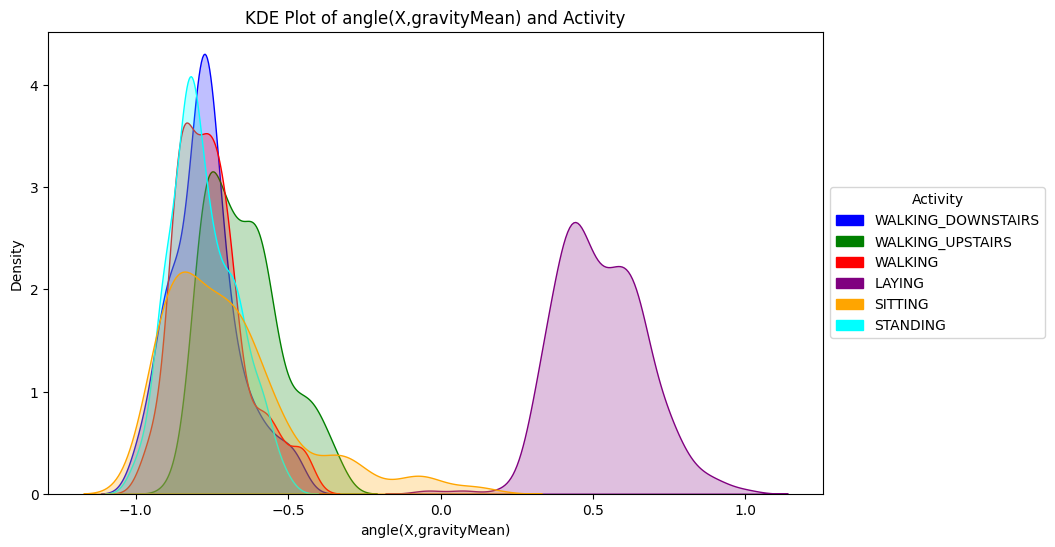

In [ ]:
print_feature_graph(data_test1, top_n_features1[0])

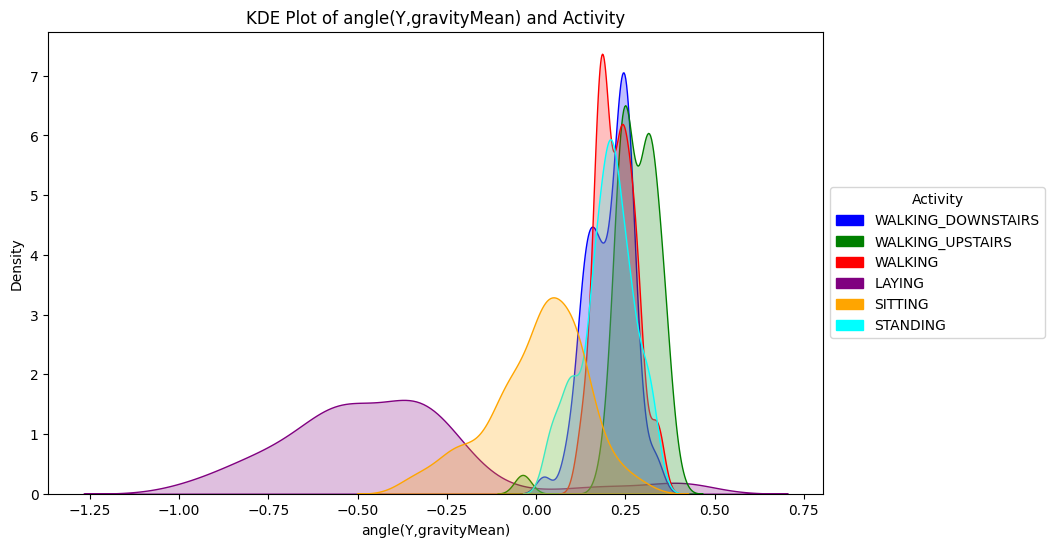

In [ ]:
print_feature_graph(data_test1, top_n_features1[1])

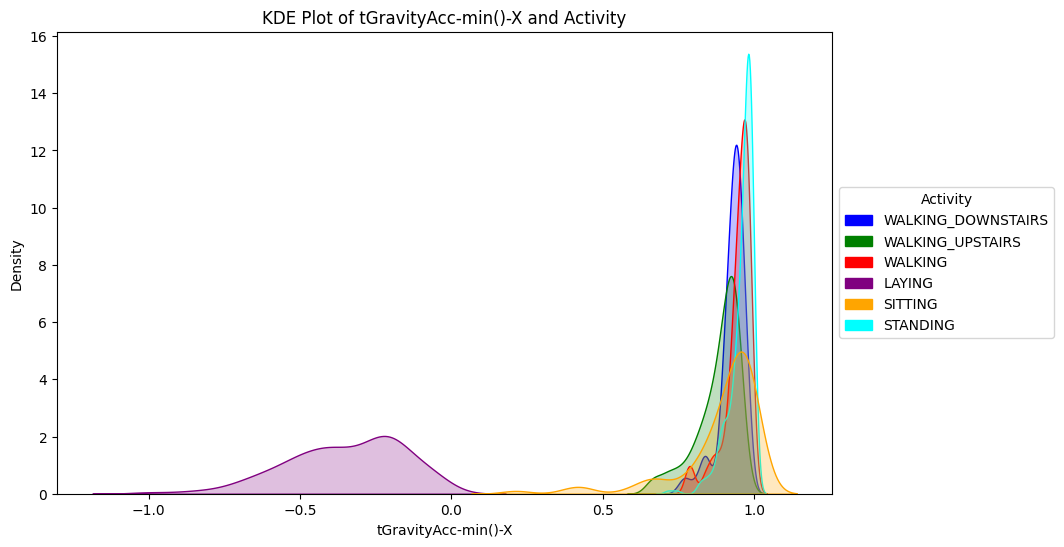

In [ ]:
print_feature_graph(data_test1, top_n_features1[2])

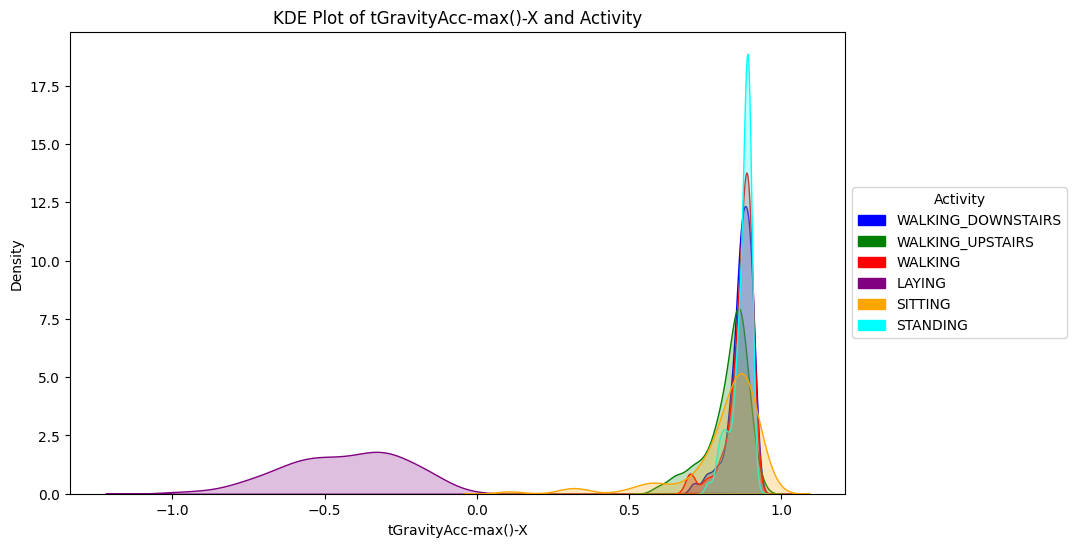

In [ ]:
print_feature_graph(data_test1, top_n_features1[3])

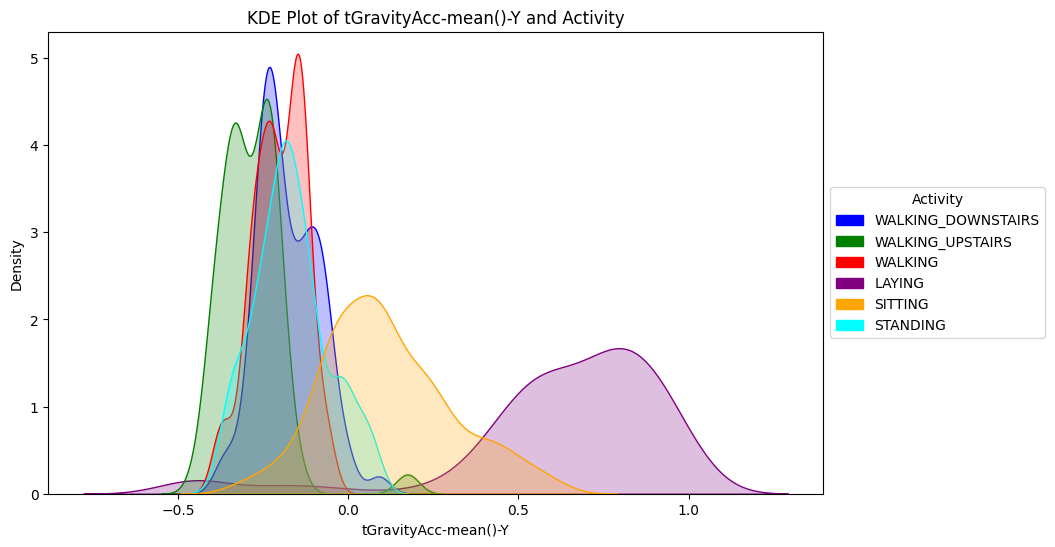

In [ ]:
print_feature_graph(data_test1, top_n_features1[4])

#### 3) 하위 5개 변수에 대한 분석

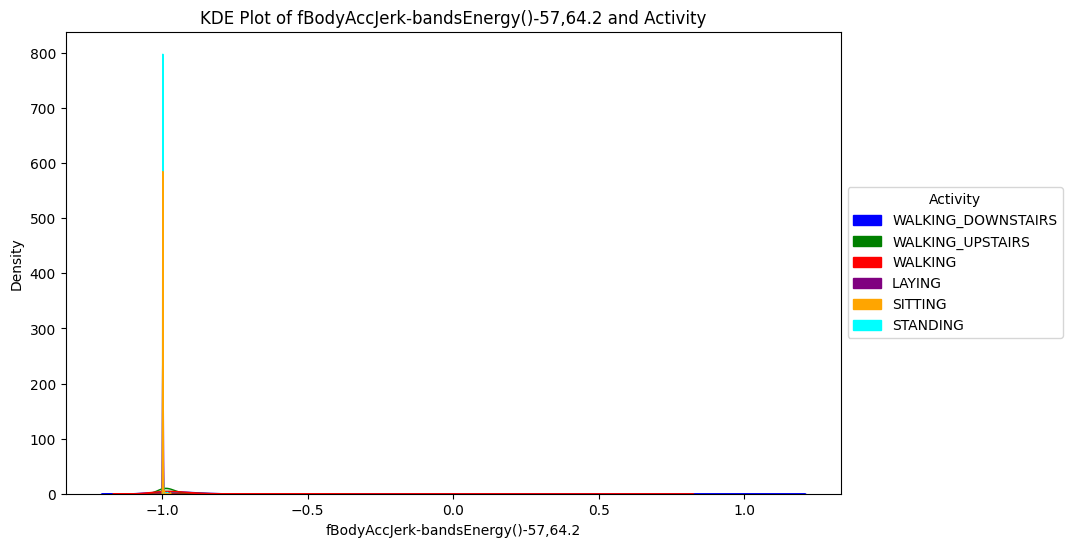

In [ ]:
print_feature_graph(data_test1, bottom_m_features1[0])

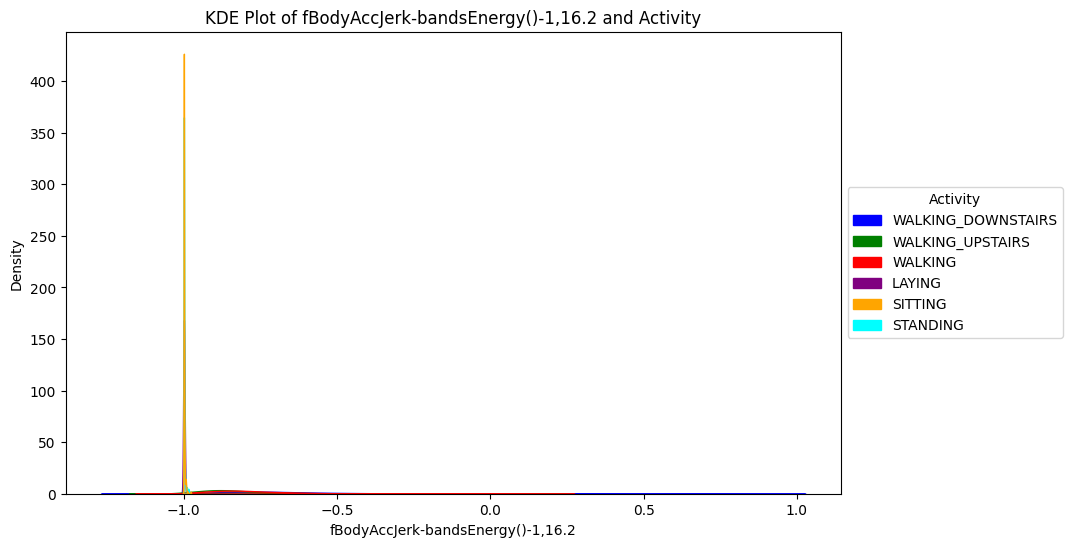

In [ ]:
print_feature_graph(data_test1, bottom_m_features1[1])

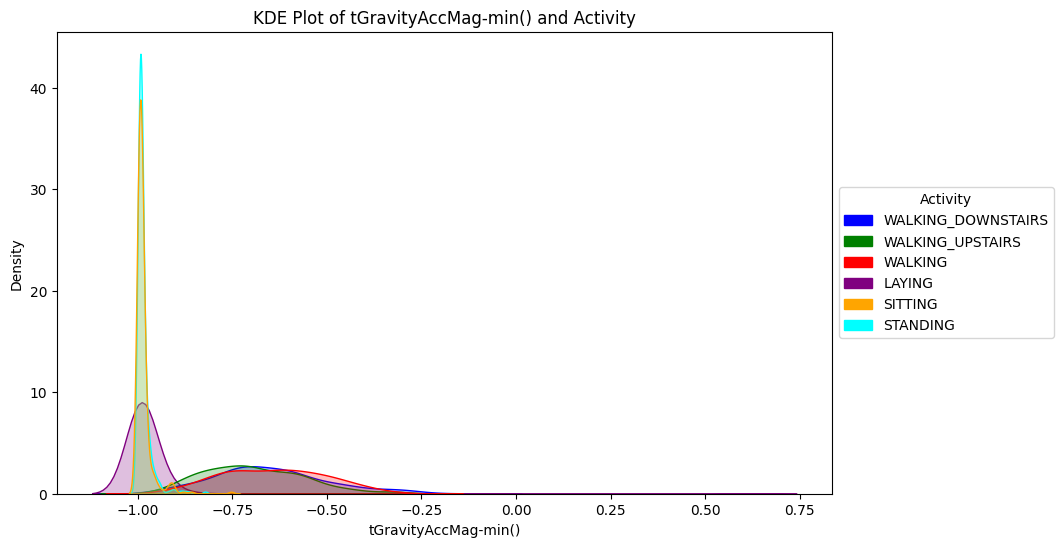

In [ ]:
print_feature_graph(data_test1, bottom_m_features1[2])

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [ ]:
data_test1 = data_test1.rename(columns={'Activity': 'is_dynamic'})

activity_mapping = {
    'STANDING': 0,
    'SITTING': 0,
    'LAYING': 0,
    'WALKING': 1,
    'WALKING_UPSTAIRS': 1,
    'WALKING_DOWNSTAIRS': 1
}

data_test1['is_dynamic'] = data_test1['is_dynamic'].map(activity_mapping)

#### 2) 기본모델 생성

In [ ]:
target = 'is_dynamic'
x2 = data_test1.drop(target, axis=1)
y2 = data_test1.loc[:, target]

x_train2, x_val2, y_train2, y_val2 = train_test_split(x2, y2, test_size=0.2, random_state=1)

In [ ]:
model2 = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=1)
model2.fit(x_train2, y_train2)

y_pred2 = model2.predict(x_val2)
print(confusion_matrix(y_val2, y_pred2))
print(classification_report(y_val2, y_pred2))

[[156   0]
 [  0 139]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       1.00      1.00      1.00       139

    accuracy                           1.00       295
   macro avg       1.00      1.00      1.00       295
weighted avg       1.00      1.00      1.00       295



In [ ]:
plot_feature_importance(model2.feature_importances_, x_train2.columns, result_only=True)

,feature_name,feature_importance
0,fBodyAccJerk-mad()-X,0.050106
1,tBodyAccJerk-energy()-X,0.050104
2,tBodyGyroJerk-iqr()-Z,0.040000
3,"fBodyAccJerk-bandsEnergy()-41,48",0.030035
4,"fBodyAccJerk-bandsEnergy()-1,24",0.030000
...,...,...
556,"tBodyGyroJerk-correlation()-Y,Z",0.000000
557,"tBodyGyroJerk-correlation()-X,Z",0.000000
558,"tBodyGyroJerk-correlation()-X,Y",0.000000
559,"tBodyGyroJerk-arCoeff()-Z,4",0.000000


#### 3) 변수중요도 상위 5개 분석

In [ ]:
top_n_features2 = ['fBodyAccJerk-mad()-X', 'tBodyAccJerk-energy()-X', 'tBodyAccJerk-mad()-X', 'fBodyAccJerk-bandsEnergy()-1,24', 'fBodyAccJerk-bandsEnergy()-1,16']

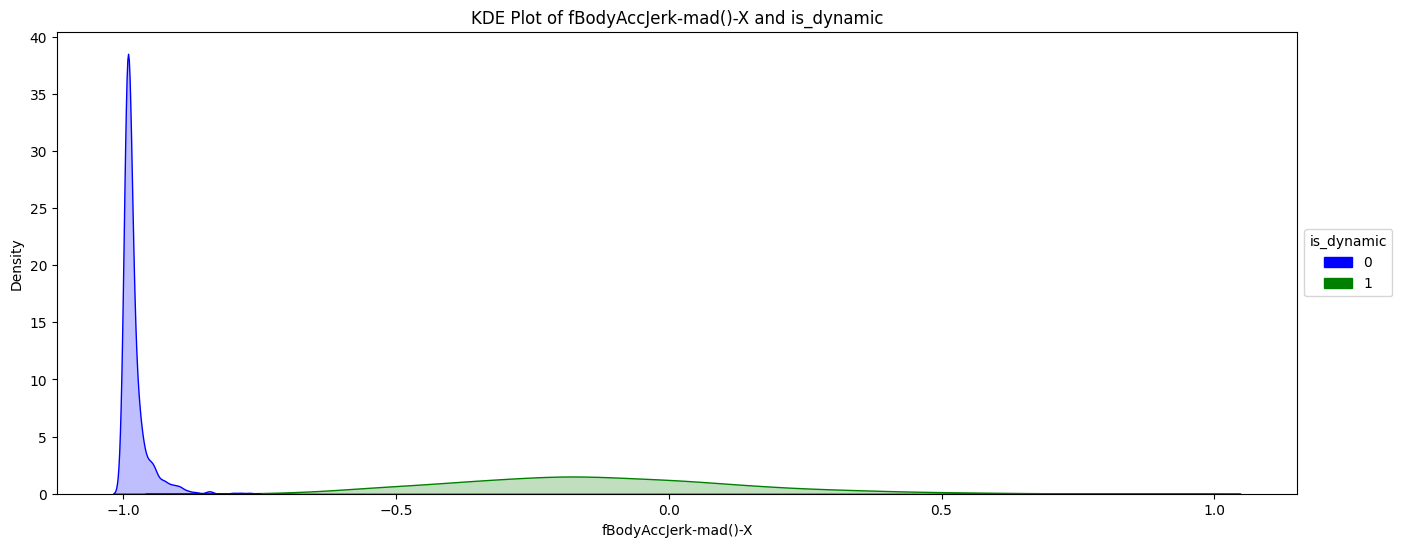

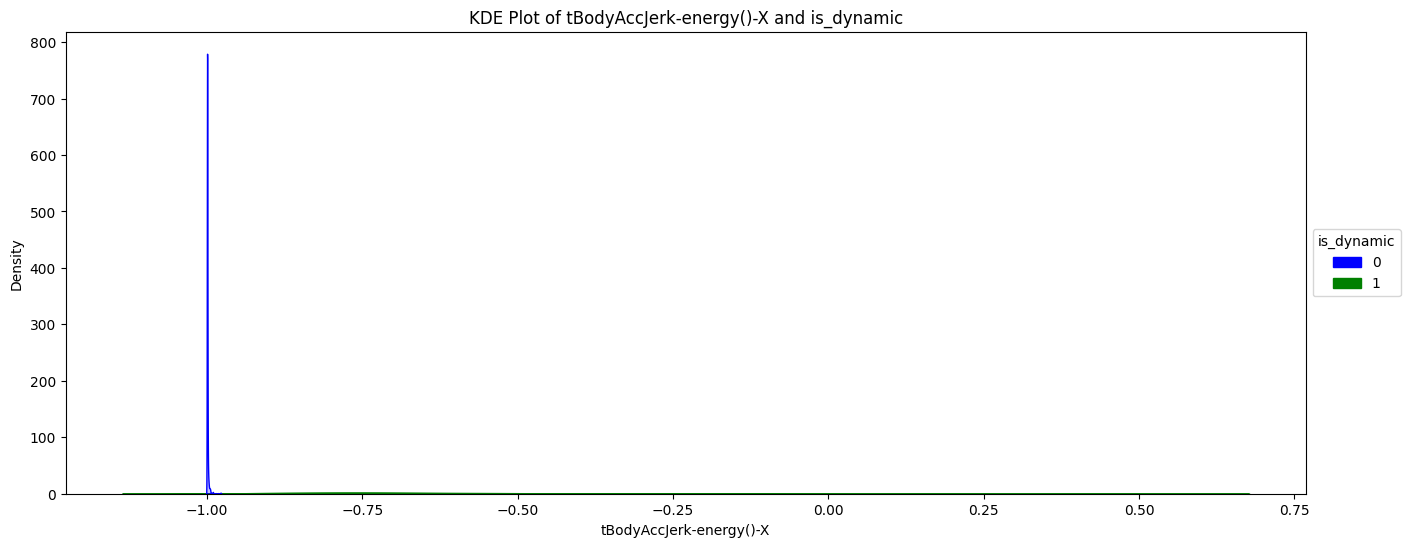

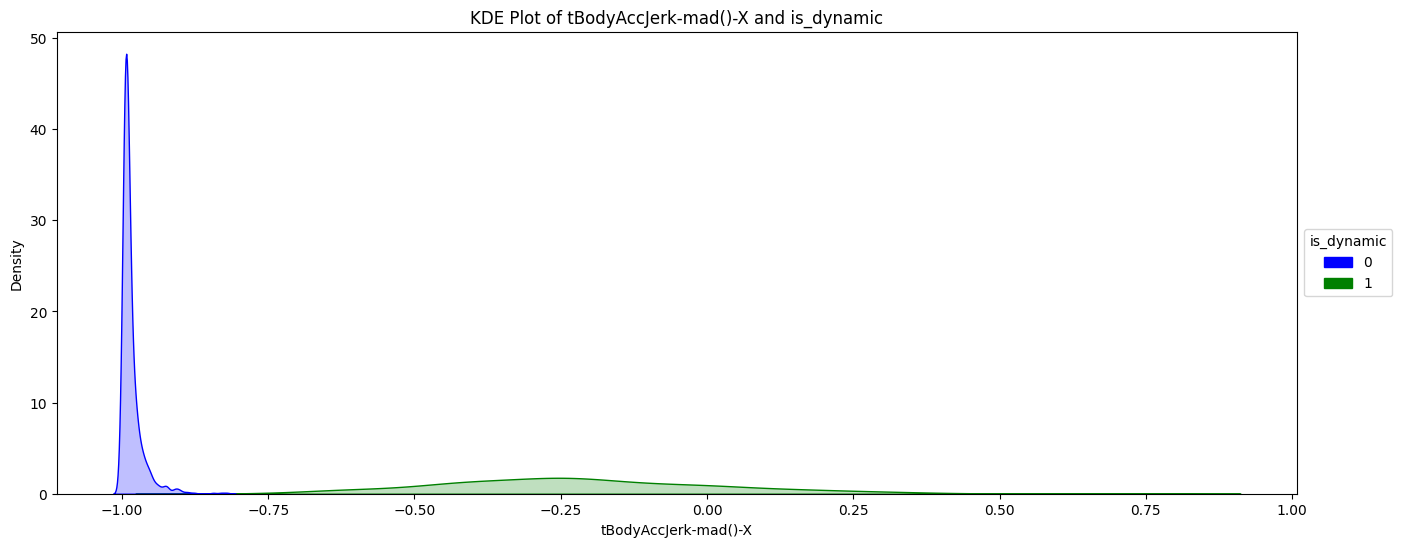

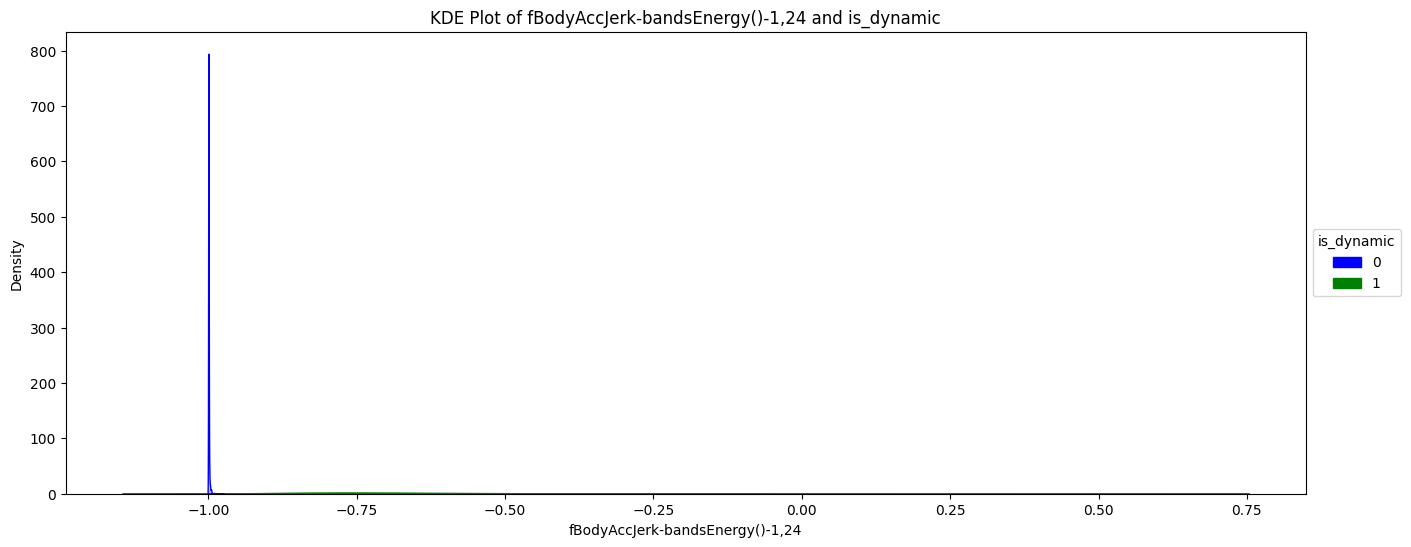

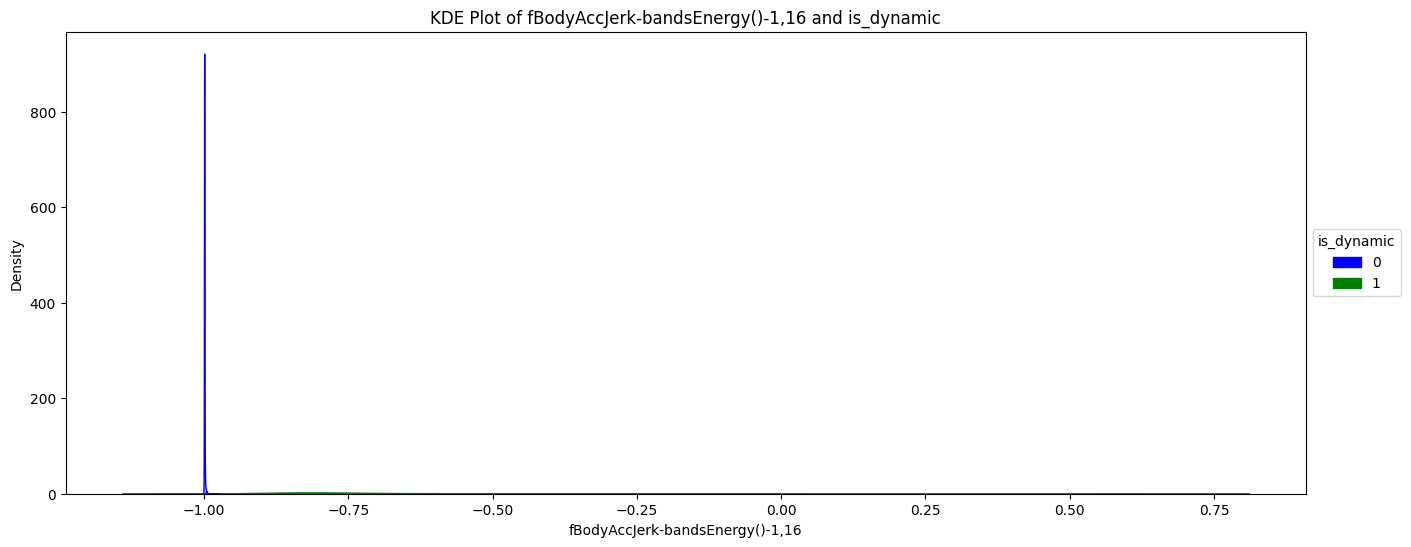

In [ ]:
activity_palette = {
    0: 'blue',
    1: 'green'
}

selected_vars2 = list(top_n_features2)

legend_patches = [mpatches.Patch(color=color, label=activity) for activity, color in activity_palette.items()]

for column in selected_vars2:
    plt.figure(figsize=(16, 6))
    sns.kdeplot(data=data_test1, x=column, hue='is_dynamic', fill=True, common_norm=False, palette=activity_palette)
    plt.title(f'KDE Plot of {column} and is_dynamic')
    plt.xlabel(column)
    plt.ylabel('Density')

    # Add custom legend
    plt.legend(handles=legend_patches, title='is_dynamic', loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

In [ ]:
# 1. Z축의 회전 변화율
# 이 플롯은 Z축의 회전 변화율이 정적 활동에서는 거의 변화하지 않고, 동적 활동에서는 약간의 변동이 발생

In [ ]:
# 2. 신체의 X축 방향으로 가속도 변화율의 최대값

In [ ]:
# 3. 특정 주파수 대역(1번에서 16번 대역)의 가속도 변화율 에너지

In [ ]:
# 4. 신체의 X축 방향으로 발생한 가속도 변화율의 표준 편차

In [ ]:
# 5. 신체의 X축 방향으로 발생한 가속도 변화율의 사분위 범위